In [1]:
!pip install torch_geometric
!pip install scikit-optimize

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data as GeoData
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

import joblib,os

from sklearn.preprocessing import StandardScaler

In [3]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [4]:
def transaction_preprocessing(df):
    # # Encode addresses and function signatures
    # # Create a single list of unique addresses from both 'from' and 'to' columns
    # all_addresses = pd.concat([df['from'], df['to']]).unique()

    # label_encoder = LabelEncoder()
    # # Fit the LabelEncoder on all unique addresses
    # label_encoder.fit(all_addresses)

    # df['from_id'] = label_encoder.fit_transform(df['from'])
    # df['to_id'] = label_encoder.transform(df['to'])

    # # Function Signature Extraction:
    # df['function_signature'] = df['input'].str.strip().replace('0x','0').apply(lambda x: x[:16] if len(x) >= 10 else x)
    # df['function_signature'] = label_encoder.fit_transform(df['function_signature'])


    # Function Signature Extraction:
    df['function_signature'] = df['input'].str.strip().replace('0x','0').apply(lambda x: x[:16] if len(x) >= 10 else x)
    df['function_signature'] = df['function_signature'].apply(lambda x: int(x, 16))

    # Contract Interaction Flag:
    df['is_contract_interaction'] = df['input'].apply(lambda x: 1 if x != '0x' else 0)

    # Input Length
    df['input_length'] = df['input'].apply(len)

    #Limit the length of the hex string to avoid overflow
    df['input'] = df['input'].str.strip().replace('0x','0').apply(lambda x: x[:16] if len(x) >= 18 else x)
    df['input'] = df['input'].apply(lambda x: int(x, 16))

    # Convert the string to a numeric type
    df['from'] = df['from'].astype(float)
    df['to'] = df['to'].astype(float)
    df['hash'] = df['hash'].astype(float)
    df['r'] = df['r'].astype(float)
    df['s'] = df['s'].astype(float)
    df['value'] = df['value'].astype(float)

    # drop duplicated
    df = df.drop_duplicates()

    return df

In [5]:
# Function to predict new data
def predict_new_data(new_data,MODEL_PATH=""):


    # Load the label encoder
    label_encoder = joblib.load(os.path.join(os.getcwd(),'label_encoder.pkl'))
    scaler = StandardScaler()

    # 1. Create an instance of your GCN model
    # Use the output_dim from the saved model (5 in this case)
    input_dim = 16
    hidden_dim = 128
    output_dim = 5  # Adjusted to match the saved model
    dropout_rate = 0.3
    model = GCN(input_dim, hidden_dim, output_dim, dropout_rate)

    # 2. Load the state dictionary into the model instance
    model.load_state_dict(torch.load(os.path.join(os.getcwd(),'final_gcn_model.pth')))
    model.eval()  # Set the model to evaluation mode

    # Preprocess new data
    new_data_processed = transaction_preprocessing(new_data)
    new_data_scaled = scaler.fit_transform(new_data_processed)
    node_features_new = torch.tensor(new_data_scaled, dtype=torch.float)

    # representing node IDs:
    unique_nodes = pd.concat([new_data_processed['from'], new_data_processed['to']]).unique()
    node_to_index = {node: index for index, node in enumerate(unique_nodes)}

    # Map 'from' and 'to' to their corresponding indices
    from_indices_new = new_data_processed['from'].map(node_to_index).fillna(-1).astype(int).values
    to_indices_new = new_data_processed['to'].map(node_to_index).fillna(-1).astype(int).values

    # Filter out invalid edges
    valid_edges_mask = (from_indices_new >= 0) & (to_indices_new >= 0)
    from_indices_new = from_indices_new[valid_edges_mask]
    to_indices_new = to_indices_new[valid_edges_mask]

    # Ensure node indices are within the valid range
    from_indices_new = np.clip(from_indices_new, 0, node_features_new.shape[0] - 1)
    to_indices_new = np.clip(to_indices_new, 0, node_features_new.shape[0] - 1)

    edge_index_new = torch.tensor([from_indices_new, to_indices_new], dtype=torch.long)
    data_new = GeoData(x=node_features_new, edge_index=edge_index_new)

    with torch.no_grad():
        output_new = model(data_new)  # Now 'model' is callable
        predictions_encoded = torch.argmax(output_new, dim=1).numpy()

    # Convert encoded predictions back to original labels
    original_predictions = label_encoder.inverse_transform(predictions_encoded)


    return new_data_processed, original_predictions

In [6]:
# Example usage for new data
new_batch = pd.read_csv("processed_pending_df.csv")

new_data_processed, new_predictions = predict_new_data(new_batch)

# Combine original features with predictions
output_df = new_data_processed.copy()
output_df['Predicted_BlockNumber'] = new_predictions

# Save combined data to CSV
output_df.to_csv('predicted_blocks_with_features.csv', index=False)

print("Predictions with features saved to 'predicted_blocks_with_features.csv'")


Predictions with features saved to 'predicted_blocks_with_features.csv'


<ipython-input-5-507c812101de>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(os.getcwd(),'final_gcn_model.pth')))
<ipython-

In [7]:
output_df.shape

(429, 17)

<Axes: xlabel='Number of Transactions', ylabel='Predicted_BlockNumber'>

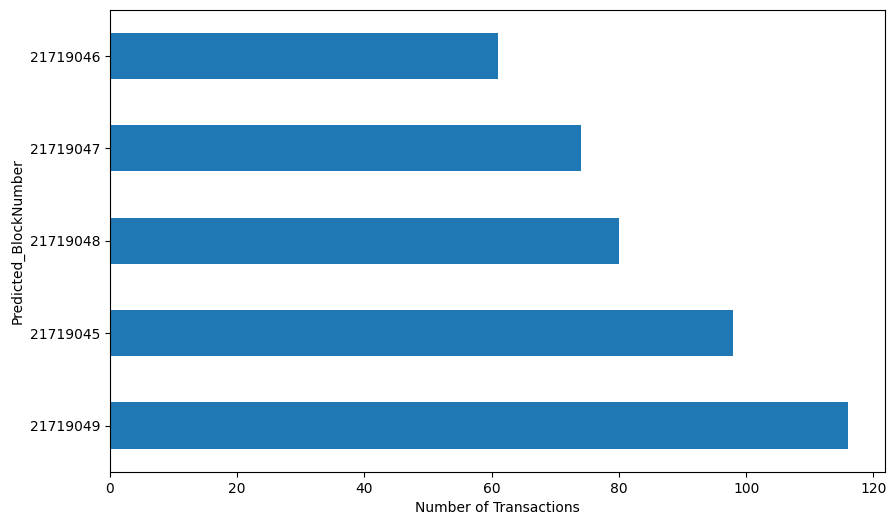

In [8]:
output_df.Predicted_BlockNumber.value_counts().plot(kind='barh', figsize=(10, 6),xlabel='Number of Transactions')